In [1]:
import sys, os, pickle
sys.path.append('/home/om2382/mft-theory/')
from cluster import *
from core import *
from empirics import *
from functions import *
from ode_methods import *
from plotting import *
from theory import *
from utils import *
import matplotlib.pyplot as plt

In [2]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 10
macro_configs = config_generator(R=[0, 1, 3, 10, 30, 100],
                                 structure=[1, 1.5, 2, 2.5, 3, 3.5, 4])

micro_configs = tuple(product(macro_configs, list(range(n_seeds))))
prototype = False

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
    prototype = True
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [39]:
#Network size
N = 1500

#Random connectivity
g = 2.5
J = g * np.random.normal(0, 1/np.sqrt(N), (N, N))

#Structure
M = 0
structure = 1
for _ in range(params['R']):
    n = np.random.normal(0, 1/np.sqrt(N), (N))
    m = params['structure'] * n /np.linalg.norm(n)**2 * N
    M = M + np.multiply.outer(m, n) / N

#Combine into one connectivity
W = J + M

In [16]:
rnn = Time_Cts_RNN(W, tanh, g=1)
ode_method = Euler(0.05)
sim = Simulation(rnn)
x_init = np.random.normal(0, 1/np.sqrt(N), N)
T = 10000
sim.run(T=T, ode_method=ode_method, x_init=x_init, monitors=['rnn.x', 'rnn.phi', 't'], T_monitor=0.05*T,
        T_monitor_interval=10)

Progress: 10.0% complete 
Time Elapsed: 28.0s 

Progress: 20.0% complete 
Time Elapsed: 56.0s 

Progress: 30.0% complete 
Time Elapsed: 83.9s 

Progress: 40.0% complete 
Time Elapsed: 111.9s 

Progress: 50.0% complete 
Time Elapsed: 139.9s 

Progress: 60.0% complete 
Time Elapsed: 167.9s 

Progress: 70.0% complete 
Time Elapsed: 195.8s 

Progress: 80.0% complete 
Time Elapsed: 223.8s 

Progress: 90.0% complete 
Time Elapsed: 251.8s 



NameError: name 'm' is not defined

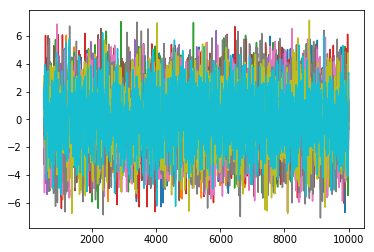

<Figure size 432x288 with 0 Axes>

In [17]:
if prototype:
    plt.figure()
    for i in range(10):
        plt.plot(sim.mons['t'], sim.mons['rnn.x'][:,i])
    #plt.ylim([-10, 10])
    
    plt.figure()
    proj = sim.mons['rnn.x'].dot(m)
    plt.plot(sim.mons['t'], proj)

In [20]:
sim.runs_x = sim.mons['rnn.x'][-int(100/ode_method.dt):,:10].copy()
sim.runs_phi = sim.mons['rnn.phi'][-int(100/ode_method.dt):,:10].copy()
sim.times = sim.mons['t'][-int(100/ode_method.dt):].copy()

dT_cov = 1
dT_cov_steps = int(dT_cov/(ode_method.dt*sim.T_monitor_interval))
PR_x = compute_approximate_participation_coefficient(sim.mons['rnn.x'][::dT_cov_steps], n_derangments=50)
PR_phi = compute_approximate_participation_coefficient(sim.mons['rnn.phi'][::dT_cov_steps], n_derangments=50)
processed_data = np.array([PR_x, PR_phi])
#processed_data = PR_x

if not prototype:
    del sim.rnn.W
    del sim.mons['rnn.x']
    del sim.mons['rnn.phi']
    del sim.mons['t']

In [ ]:
### --- SAVE RESULTS -- ###
result = {'sim': sim, 'i_seed': i_seed, 'config': params,
          'i_config': i_config, 'i_job': i_job}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
except KeyError:
    pass

In [40]:
###Truncate file above
file_name = 'empirical_dimensionality'
job_name = 'dim_rank_structure_scale'
project_dir = '/home/om2382/low-rank-dims/'
main_script_path = os.path.join(project_dir, 'cluster_main_scripts', job_name + '.py')
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py {}'.format(file_name, main_script_path))

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook empirical_dimensionality.ipynb to script
[NbConvertApp] Writing 9811 bytes to empirical_dimensionality.py
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2b071b7efdd8> <built-in function print>
awk: cmd. line:1:                       ^ syntax error
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2b071b7efdd8> <built-in function print>
awk: cmd. line:1:                                                                                ^ syntax error


In [41]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name), mem=16, n_hours=6)
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
job_id_1 = submit_job(job_script_path, n_jobs)

rm: cannot remove ‘/home/om2382/low-rank-dims/results/misc/dim_rank_structure_scale/result_*’: No such file or directory
sending incremental file list
mft-theory/
mft-theory/.DS_Store
mft-theory/.gitignore
mft-theory/README.md
mft-theory/__init__.py
mft-theory/jupyter_notebook.py
mft-theory/main.ipynb
mft-theory/.idea/
mft-theory/.idea/mft-theory.iml
mft-theory/.idea/misc.xml
mft-theory/.idea/modules.xml
mft-theory/.idea/vanilla-rtrl.iml
mft-theory/.idea/vcs.xml
mft-theory/.idea/workspace.xml
mft-theory/.idea/codeStyles/
mft-theory/.idea/codeStyles/codeStyleConfig.xml
mft-theory/.ipynb_checkpoints/
mft-theory/.ipynb_checkpoints/main-checkpoint.ipynb
mft-theory/cluster/
mft-theory/cluster/__init__.py
mft-theory/cluster/close_jupyter_notebook.py
mft-theory/cluster/process_results.py
mft-theory/cluster/start_jupyter_notebook.py
mft-theory/cluster/submit_jobs.py
mft-theory/cluster/sync_cluster.py
mft-theory/core/
mft-theory/core/Simulation.py
mft-theory/core/Time_Cts_RNN.py
mft-theory/core

In [7]:
###Get job status
get_ipython().system('squeue -u om2382')

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           1288178    lkumar  jupyter   om2382  R      49:39      1 ax15


In [4]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'dim_rank_structure_scale'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
configs_array, results_array, key_order, sim_dict = unpack_processed_data(job_script_path)

In [5]:
results_array.shape

(6, 7, 10, 2)

In [6]:
configs_array

{'R': [0, 1, 3, 10, 30, 100],
 'structure': [1, 1.5, 2, 2.5, 3, 3.5, 4],
 'i_seed': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]}

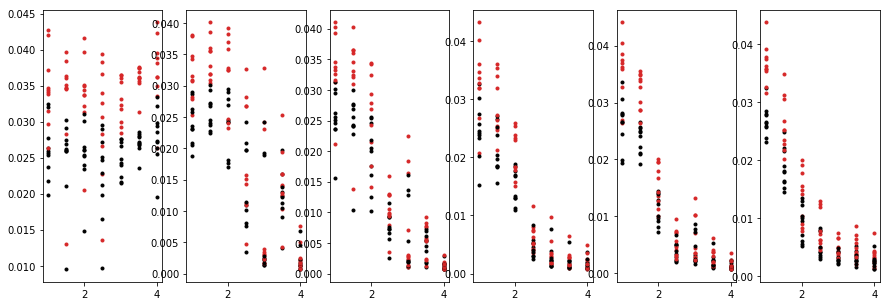

In [8]:
fig, ax = plt.subplots(1, 6, figsize=(15, 5))
for i_ax in range(6):
    for i_seed in range(10):
        ax[i_ax].plot(configs_array['structure'], results_array[i_ax,:,i_seed,0], '.', color='k')
        ax[i_ax].plot(configs_array['structure'], results_array[i_ax,:,i_seed,1], '.', color='C3')

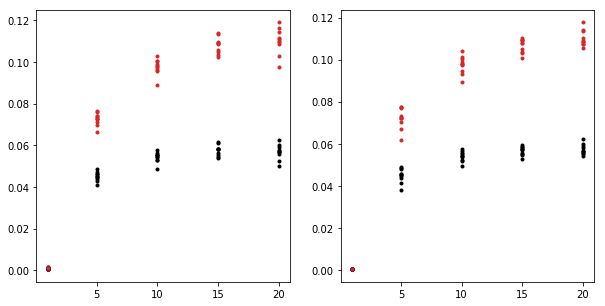

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i_ax in range(2):
    for i_seed in range(10):
        ax[i_ax].plot(configs_array['g'], results_array[i_ax,:,i_seed,0], '.', color='k')
        ax[i_ax].plot(configs_array['g'], results_array[i_ax,:,i_seed,1], '.', color='C3')

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
for i_ax in range(3):
    ax[i_ax].set_title('N = {}'.format(configs_array['N'][i_ax]))
    for i_seed in range(10):
        ax[i_ax].plot(configs_array['structure'], results_array[i_ax,:,i_seed], '.', color='k')

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
for i_ax in range(2):
    ax[i_ax].set_title('N = {}'.format(configs_array['N'][i_ax]))
    for i_seed in range(10):
        ax[i_ax].plot(configs_array['structure'], results_array[i_ax,:,i_seed], '.', color='k')

In [ ]:
plt.plot(configs_array['structure'], results_array[:,:,0].mean(1), '.', color='k')
plt.plot(configs_array['structure'], results_array[:,:,1].mean(1), '.', color='r')
plt.xlabel(key_order[0])

In [ ]:
for i in range(10):
    plt.plot(configs_array['structure'], results_array[:,i,0], '.', color='k')
    #plt.plot(configs_array['structure'], results_array[:,i,1], '.', color='r')
plt.xlabel(key_order[0])
plt.ylabel('$PR_x$')
plt.title('N = 1000, g = 2.25')

In [ ]:
theory = []
for g in configs_array['g']:
    theory.append(solve_for_Delta_0(g))
#plt.plot(configs_array['g'], theory, color='k')
for i in range(len(configs_array['n'])):
    fig = plt.figure()
    plt.plot(configs_array['g'], theory, color='k')
    for j in range(len(configs_array['i_seed'])):
        plt.plot(configs_array['g'], results_array[i, :, j], '.', color='C{}'.format(i))
    plt.xlabel('g')
    plt.ylabel('$\Delta_0$')
    plt.title('n = {}'.format(configs_array['n'][i]))
    plt.xticks(configs_array['g'])
    plt.ylim([-0.05, 3.5])
    fig.savefig('figs/delta0_n={}.pdf'.format(configs_array['n'][i]), format='pdf')

In [ ]:
def plot_2d_array_of_time_series(configs_array, results_array, common_ylim=None):
    
    n_x, n_y, n_seeds, n_t = results_array.shape[:]
    keys = [key for key in configs_array.keys()]
    fig, ax = plt.subplots(n_x, n_y, figsize=(10,10))
    for i in range(n_x):
        for j in range(n_y):
            for k in range(n_seeds):
                ax[i, j].plot(results_array[i,j,k,:], color='C0')
            if common_ylim is not None:
                ax[i, j].set_ylim(common_ylim)
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[0, j].set_title('{} = {}'.format(keys[1], configs_array[keys[1]][j]))
            ax[i, 0].set_ylabel('{} = {}'.format(keys[0], configs_array[keys[0]][i]))

In [ ]:
plot_2d_array_of_time_series(configs_array, results_array)

In [ ]:
results_array.shape
fig, ax = plt.subplots(4, 3, figsize=(10, 10))
for i in range(4):
    for j in range(3):
        for k in range(5):
            ax[i,j].plot(results_array[i,j,k,::100], color='C0')
            #ax[i,j].set_ylim([-0.01, 0.01])

#fig.savefig('figs/n_ginit.pdf', format='pdf')

In [ ]:
fig = plot_3d_or_4d_array_of_config_results(configs_array, results_array, key_order,
                                            tick_rounding=5, vmin=0, vmax=0.02, cmap='Blues')
#fig.savefig('figs/T_n_dt_pr.pdf')

In [ ]:
results_array.shape

In [ ]:
fig = plt.figure()
colors = ['k', 'C3']
#colors = ['g', 'y']
for i_pr, pr in enumerate(['Demeaned X', 'X', 'Demeaned Phi', 'Phi']):
    for i_seed, seed in enumerate(configs_array['i_seed']):
        plt.plot(configs_array['structure'], results_array[:, 9, i_seed, i_pr], '.', color=colors[i_pr//2])
plt.xticks(configs_array['structure'])
plt.ylim([0, 0.03])
plt.xticks([0, 1, 2, 3, 4])
plt.xlabel('mn/N')
plt.ylabel('$PR$')
#plt.axhline(y=0.0602, color='k', linestyle='--')
#plt.axhline(y=0.126, color='k', linestyle='--')
#fig.savefig('figs/mean_demeaned_structure_pr.pdf')

In [ ]:
fig, ax = plt.subplots(16, 16, figsize=(30, 30))
for i in range(10):
    for i_s, s in enumerate(configs_array['structure']):
        for i_g, g in enumerate(configs_array['g']):
            ax[15 - i_s, i_g].plot(sim_dict['{}_{}_0'.format(s, g)].runs_x[:,i], color='C{}'.format(i))
            ax[i_s, i_g].axis('off')
            #ax[i_s].axhline(y=sim_dict['{}_0'.format(s)].runs_x[:,i].mean(), color='C{}'.format(i))
            #ax[i_s].set_ylim([-3, 3])

In [ ]:
#fig.savefig('figs/dim_bifurcations.pdf')

In [ ]:
!ls figs

In [ ]:
fig, ax = plt.subplots(4, 4, figsize=(16, 16))
colors = ['k', 'C3']
for i_ax, g in enumerate(configs_array['g']):
    i_x = i_ax // 4
    i_y = i_ax % 4
    for i_pr, pr in enumerate(['Demeaned X', 'X', 'Demeaned Phi', 'Phi']):
        for i_seed, seed in enumerate(configs_array['i_seed']):
            ax[i_x, i_y].plot(configs_array['structure'], results_array[:, i_ax, i_seed, i_pr], '.', color=colors[i_pr//2])
    ax[i_x, i_y].set_xticks(configs_array['structure'])
    ax[i_x, i_y].set_ylim([-0.01, 0.08])
    ax[i_x, i_y].set_xticks([0, 1, 2, 3, 4])
    #ax[i_x, i_y].axis('off')
    ax[i_x, i_y].set_title('g = {}'.format(g))
    ax[i_x, i_y].set_xlabel('mn/N')
    plt.tight_layout()